In [1]:
# https://www.kaggle.com/gpreda/data-science-bowl-fast-compact-solution
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/data-science-bowl-2019.zip
../data/test.csv
../data/sample_submission.csv
../data/train_labels.csv
../data/train.csv
../data/specs.csv


In [2]:
import numpy as np
import pandas as pd
import os
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from numba import jit 

In [3]:
def read_data():
    print(f'Read data')
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    train_labels_df = pd.read_csv('../data/train_labels.csv')
    specs_df = pd.read_csv('../data/specs.csv')
    sample_submission_df = pd.read_csv('../data/sample_submission.csv')
    
    return train_df, test_df, train_labels_df, specs_df, sample_submission_df

In [4]:
# def extract_time_features(df):
#     df['timestamp'] = pd.to_datetime(df['timestamp'])
#     df['date'] = df['timestamp'].dt.date
#     df['month'] = df['timestamp'].dt.month
#     df['hour'] = df['timestamp'].dt.hour
#     #df['year'] = df['timestamp'].dt.year
#     df['dayofweek'] = df['timestamp'].dt.dayofweek
#     #df['weekofyear'] = df['timestamp'].dt.weekofyear
#     #df['dayofyear'] = df['timestamp'].dt.dayofyear
#     #df['quarter'] = df['timestamp'].dt.quarter
#     #df['is_month_start'] = df['timestamp'].dt.is_month_start   

In [5]:
def extract_time_features(df):
#     year, month, day : int
#     hour, minute, second, microsecond : int, optional, default 0
#     nanosecond : int, optional, default 0
#     tzinfo : datetime.tzinfo, optional, default None

#     dayofweek	Return day of whe week.
#     dayofyear	Return the day of the year.
#     days_in_month	Return the number of days in the month.
#     daysinmonth	Return the number of days in the month.
#     freqstr	Return the total number of days in the month.
#     is_leap_year	Return True if year is a leap year.
#     is_month_end	Return True if date is last day of month.
#     is_month_start	Return True if date is first day of month.
#     is_quarter_end	Return True if date is last day of the quarter.
#     is_quarter_start	Return True if date is first day of the quarter.
#     is_year_end	Return True if date is last day of the year.
#     is_year_start	Return True if date is first day of the year.
#     quarter	Return the quarter of the year.
#     resolution	Return resolution describing the smallest difference between two times that can be represented by Timestamp object_state
#     tz	Alias for tzinfo
#     week	Return the week number of the year.
    df['timestamp'] = df['timestamp'].map(lambda x: pd.Timestamp(x))
#     df['day'] = df['timestamp'].map(lambda x: 'd_'+str(x.day))
    df['month'] = df['timestamp'].map(lambda x: 'm_'+str(x.month))
    df['hour'] = df['timestamp'].map(lambda x: 'h_'+str(x.hour))
    #df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].map(lambda x: 'dow_'+str(x.dayofweek))
#     df['weekofyear'] = df['timestamp'].map(lambda x: 'woy_'+str(x.weekofyear))
#     df['dayofyear'] = df['timestamp'].map(lambda x: 'doy_'+str(x.dayofyear))
    df['quarter'] = df['timestamp'].map(lambda x: 'q_'+str(x.quarter))
    df['is_month_start'] = df['timestamp'].map(lambda x: 'ims_'+str(x.is_month_start))
    df['is_month_end'] = df['timestamp'].map(lambda x: 'ime_'+str(x.is_month_end))
#     df['is_quarter_end'] = df['timestamp'].map(lambda x: 'iqe_'+str(x.is_quarter_end))
#     df['is_quarter_start'] = df['timestamp'].map(lambda x: 'iqs_'+str(x.is_quarter_start))
#     df['is_year_end'] = df['timestamp'].map(lambda x: 'iye_'+str(x.is_year_end))
#     df['is_year_start'] = df['timestamp'].map(lambda x: 'iys_'+str(x.is_year_start))
    
    return df

In [6]:
def get_object_columns(df, columns):
    df = df.groupby(['installation_id', columns])['event_id'].count().reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [columns], values = 'event_id')
    df.columns = list(df.columns)
    df.fillna(0, inplace = True)
    return df

In [7]:
def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': ['mean', 'sum', 'min', 'max', 'std']})
    df.fillna(0, inplace = True)
    df.columns = [f'{column}_mean', f'{column}_sum', f'{column}_min', f'{column}_max', f'{column}_std']
    return df

In [8]:
def get_numeric_columns_add(df, agg_column, column):
    df = df.groupby(['installation_id', agg_column]).agg({f'{column}': ['mean', 'sum', 'min', 'max', 'std']}).reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [agg_column], values = [col for col in df.columns if col not in ['installation_id', 'type']])
    df.fillna(0, inplace = True)
    df.columns = list(df.columns)
    return df

In [9]:
def perform_features_engineering(train_df, test_df, train_labels_df):
    print(f'Perform features engineering')
    numerical_columns = ['game_time']
    categorical_columns = ['type', 'world', 'dayofweek', 'hour', 'month', 'quarter', 'is_month_start', 
                           'is_month_end']
#     categorical_columns = ['dayofweek']
#      df['day'] = df['timestamp'].map(lambda x: x.day)
#     df['month'] = df['timestamp'].map(lambda x: x.month)
#     df['hour'] = df['timestamp'].map(lambda x: x.year)
#     #df['year'] = df['timestamp'].dt.year
#     df['dayofweek'] = df['timestamp'].map(lambda x: x.dayofweek)
#     df['weekofyear'] = df['timestamp'].map(lambda x: x.weekofyear)
#     df['dayofyear'] = df['timestamp'].map(lambda x: x.dayofyear)
#     df['quarter'] = df['timestamp'].map(lambda x: x.quarter)
#     df['is_month_start'] = df['timestamp'].map(lambda x: x.is_month_start)
#     df['is_month_end'] = df['timestamp'].map(lambda x: x.is_month_end)
#     df['is_quarter_end'] = df['timestamp'].map(lambda x: x.is_quarter_end)
#     df['is_quarter_start'] = df['timestamp'].map(lambda x: x.is_quarter_start)
#     df['is_year_end'] = df['timestamp'].map(lambda x: x.is_year_end)
#     df['is_year_start'] = df['timestamp'].map(lambda x: x.is_year_start)
    
    comp_train_df = pd.DataFrame({'installation_id': train_df['installation_id'].unique()})
    comp_train_df.set_index('installation_id', inplace = True)
    comp_test_df = pd.DataFrame({'installation_id': test_df['installation_id'].unique()})
    comp_test_df.set_index('installation_id', inplace = True)

    test_df = extract_time_features(test_df)
    train_df = extract_time_features(train_df)

    for i in numerical_columns:
        comp_train_df = comp_train_df.merge(get_numeric_columns(train_df, i), left_index = True, right_index = True)
        comp_test_df = comp_test_df.merge(get_numeric_columns(test_df, i), left_index = True, right_index = True)
    
    for i in categorical_columns:
        comp_train_df = comp_train_df.merge(get_object_columns(train_df, i), left_index = True, right_index = True)
        comp_test_df = comp_test_df.merge(get_object_columns(test_df, i), left_index = True, right_index = True)
    
    for i in categorical_columns:
        for j in numerical_columns:
            comp_train_df = comp_train_df.merge(get_numeric_columns_add(train_df, i, j), left_index = True, right_index = True)
            comp_test_df = comp_test_df.merge(get_numeric_columns_add(test_df, i, j), left_index = True, right_index = True)
    
    
    comp_train_df.reset_index(inplace = True)
    comp_test_df.reset_index(inplace = True)
    
    print('Our training set have {} rows and {} columns'.format(comp_train_df.shape[0], comp_train_df.shape[1]))

    # get the mode of the title
    labels_map = dict(train_labels_df.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
    # merge target
    labels = train_labels_df[['installation_id', 'title', 'accuracy_group']]
    # replace title with the mode
    labels['title'] = labels['title'].map(labels_map)
    # get title from the test set
    comp_test_df['title'] = test_df.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop = True)
    # join train with labels
    comp_train_df = labels.merge(comp_train_df, on = 'installation_id', how = 'left')
    print('We have {} training rows'.format(comp_train_df.shape[0]))
    
    return comp_train_df, comp_test_df


In [10]:
@jit
def qwk3(a1, a2, max_rat=3):
#     print(len(a1), len(a2))
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)
    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))
    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)
    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)
    e = e / a1.shape[0]
    return 1 - o / e


In [11]:
def run_model(comp_train_df, comp_test_df):
    print(f'Run model')
    num_splits = 10
    kf = KFold(n_splits=num_splits)
    features = [i for i in comp_train_df.columns if i not in ['accuracy_group', 'installation_id']]
    target = 'accuracy_group'
    oof_pred = np.zeros((len(comp_train_df), 4))
    y_pred = np.zeros((len(comp_test_df), 4))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(comp_train_df)):
        print('\n=======\nFold {}\n=======\n'.format(fold + 1))
        x_train, x_val = comp_train_df[features].iloc[tr_ind], comp_train_df[features].iloc[val_ind]
        y_train, y_val = comp_train_df[target][tr_ind], comp_train_df[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)

        params = {
            'learning_rate': 0.007,
            'metric': 'multiclass',
            'objective': 'multiclass',
            'num_classes': 4,
            'feature_fraction': 0.75,
            "bagging_fraction": 0.8,
            "bagging_seed": 42,
        }

        model = lgb.train(params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                          valid_sets=[train_set, val_set], verbose_eval = 100)
        oof_pred[val_ind] = model.predict(x_val)
        y_pred += model.predict(comp_test_df[features]) / num_splits
        
        val_crt_fold = qwk3(y_val, oof_pred[val_ind].argmax(axis = 1))
        print(f'Fold: {fold+1} quadratic weighted kappa score: {np.round(val_crt_fold,4)}')
        
    res = qwk3(comp_train_df['accuracy_group'], oof_pred.argmax(axis = 1))
    print(f'Quadratic weighted score: {np.round(res,4)}')
        
    return y_pred

In [12]:
def prepare_submission(comp_test_df, sample_submission_df, y_pred):
    comp_test_df = comp_test_df.reset_index()
    comp_test_df = comp_test_df[['installation_id']]
    comp_test_df['accuracy_group'] = y_pred.argmax(axis = 1)
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(comp_test_df, on = 'installation_id')
    sample_submission_df.to_csv('../cache/submission.csv', index = False)

    


In [13]:
train_df, test_df, train_labels_df, specs_df, sample_submission_df = read_data()


Read data


In [14]:
train_df.head(1)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE


In [15]:
comp_train_df, comp_test_df = perform_features_engineering(train_df, test_df, train_labels_df)

Perform features engineering


/home/watts/anaconda3/envs/dsb19/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Our training set have 17000 rows and 300 columns


/home/watts/anaconda3/envs/dsb19/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We have 17690 training rows


In [16]:
comp_train_df.shape

(17690, 302)

In [17]:
pd.set_option('display.max_columns', None)
comp_train_df.head(1)

,installation_id,title,accuracy_group,game_time_mean,game_time_sum,game_time_min,game_time_max,game_time_std,Activity,Assessment,Clip,Game,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,h_0,h_1,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_2,h_20,h_21,h_22,h_23,h_3,h_4,h_5,h_6,h_7,h_8,h_9,m_10,m_7,m_8,m_9,q_3,q_4,ims_False,ims_True,ime_False,ime_True,"(game_time, max, Activity)","(game_time, max, Assessment)","(game_time, max, Clip)","(game_time, max, Game)","(game_time, mean, Activity)","(game_time, mean, Assessment)","(game_time, mean, Clip)","(game_time, mean, Game)","(game_time, min, Activity)","(game_time, min, Assessment)","(game_time, min, Clip)","(game_time, min, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)","(game_time, sum, Activity)","(game_time, sum, Assessment)","(game_time, sum, Clip)","(game_time, sum, Game)","(game_time, max, CRYSTALCAVES)","(game_time, max, MAGMAPEAK)","(game_time, max, NONE)","(game_time, max, TREETOPCITY)","(game_time, mean, CRYSTALCAVES)","(game_time, mean, MAGMAPEAK)","(game_time, mean, NONE)","(game_time, mean, TREETOPCITY)","(game_time, min, CRYSTALCAVES)","(game_time, min, MAGMAPEAK)","(game_time, min, NONE)","(game_time, min, TREETOPCITY)","(game_time, std, CRYSTALCAVES)","(game_time, std, MAGMAPEAK)","(game_time, std, NONE)","(game_time, std, TREETOPCITY)","(game_time, sum, CRYSTALCAVES)","(game_time, sum, MAGMAPEAK)","(game_time, sum, NONE)","(game_time, sum, TREETOPCITY)","(game_time, max, dow_0)","(game_time, max, dow_1)","(game_time, max, dow_2)","(game_time, max, dow_3)","(game_time, max, dow_4)","(game_time, max, dow_5)","(game_time, max, dow_6)","(game_time, mean, dow_0)","(game_time, mean, dow_1)","(game_time, mean, dow_2)","(game_time, mean, dow_3)","(game_time, mean, dow_4)","(game_time, mean, dow_5)","(game_time, mean, dow_6)","(game_time, min, dow_0)","(game_time, min, dow_1)","(game_time, min, dow_2)","(game_time, min, dow_3)","(game_time, min, dow_4)","(game_time, min, dow_5)","(game_time, min, dow_6)","(game_time, std, dow_0)","(game_time, std, dow_1)","(game_time, std, dow_2)","(game_time, std, dow_3)","(game_time, std, dow_4)","(game_time, std, dow_5)","(game_time, std, dow_6)","(game_time, sum, dow_0)","(game_time, sum, dow_1)","(game_time, sum, dow_2)","(game_time, sum, dow_3)","(game_time, sum, dow_4)","(game_time, sum, dow_5)","(game_time, sum, dow_6)","(game_time, max, h_0)","(game_time, max, h_1)","(game_time, max, h_10)","(game_time, max, h_11)","(game_time, max, h_12)","(game_time, max, h_13)","(game_time, max, h_14)","(game_time, max, h_15)","(game_time, max, h_16)","(game_time, max, h_17)","(game_time, max, h_18)","(game_time, max, h_19)","(game_time, max, h_2)","(game_time, max, h_20)","(game_time, max, h_21)","(game_time, max, h_22)","(game_time, max, h_23)","(game_time, max, h_3)","(game_time, max, h_4)","(game_time, max, h_5)","(game_time, max, h_6)","(game_time, max, h_7)","(game_time, max, h_8)","(game_time, max, h_9)","(game_time, mean, h_0)","(game_time, mean, h_1)","(game_time, mean, h_10)","(game_time, mean, h_11)","(game_time, mean, h_12)","(game_time, mean, h_13)","(game_time, mean, h_14)","(game_time, mean, h_15)","(game_time, mean, h_16)","(game_time, mean, h_17)","(game_time, mean, h_18)","(game_time, mean, h_19)","(game_time, mean, h_2)","(game_time, mean, h_20)","(game_time, mean, h_21)","(game_time, mean, h_22)","(game_time, mean, h_23)","(game_time, mean, h_3)","(game_time, mean, h_4)","(game_time, mean, h_5)","(game_time, mean, h_6)","(game_time, mean, h_7)","(game_time, mean, h_8)","(game_time, mean, h_9)","(game_time, min, h_0)","(game_time, min, h_1)","(game_time, min, h_10)","(game_time, min, h_11)","(game_time, min, h_12)","(game_time, min, h_13)","(game_time, min, h_14)","(game_time, min, h_15)","(game_time, min, h_16)","(game_time, min, h_17)","(game_time, min, h_18)","(game_time, min, h_19)","(game_time, min, h_2)","(gam

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.scorer import make_scorer
my_scorer = make_scorer(qwk3, greater_is_better=True)
# def run_model_rfe(comp_train_df, comp_test_df):
#     print(f'Run model RFE')
#     num_splits = 10
#     kf = KFold(n_splits=num_splits)
   
features = [i for i in comp_train_df.columns if i not in ['accuracy_group', 'installation_id']]
target = 'accuracy_group'
target = comp_train_df['accuracy_group']
#     oof_pred = np.zeros((len(comp_train_df), 4))
#     y_pred = np.zeros((len(comp_test_df), 4))
#     params = {
#             'learning_rate': 0.007,
#             'metric': 'multiclass',
#             'objective': 'multiclass',
#             'num_classes': 4,
#             'feature_fraction': 0.75,
#             "bagging_fraction": 0.8,
#             "bagging_seed": 42,
#     }
#     x_train = comp_train_df[features]
#     y_train = comp_train_df[target]
#     train_set = lgb.Dataset(x_train, y_train)
#     lgbc =  lgb.train(params, train_set, num_boost_round = 10000)
model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced', objective='multiclass',
                           colsample_bytree=0.75, learning_rate=0.007,
                           subsample=0.8)
X = comp_train_df[features]
print(X.shape)
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(3), scoring=my_scorer)
rfecv.fit(X, target)
print('Optimal number of features: {}'.format(rfecv.n_features_))
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)
print(dset)

(17690, 300)


<ipython-input-10-c39e70a92ec8>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk3" failed type inference due to: Invalid use of Function(<function asarray at 0x7f1b1415cb70>) with argument(s) of type(s): (array(int64, 1d, C), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    AttributeError: 'Function' object has no attribute 'dtype'
    raised from /home/watts/anaconda3/envs/dsb19/lib/python3.7/site-packages/numba/targets/arraymath.py:3845
In definition 1:
    AttributeError: 'Function' object has no attribute 'dtype'
    raised from /home/watts/anaconda3/envs/dsb19/lib/python3.7/site-packages/numba/targets/arraymath.py:3845
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function asarray at 0x7f1b1415cb70>)
[2] During: typing of call at <ipython-input-10-c39e70a92ec8> (5)


File "<ipython-input-10-c39e70a92e

Optimal number of features: 35


ValueError: Length of values does not match length of index

In [19]:
dset = pd.DataFrame()

dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

In [20]:
print(dset)

    importance
17         921
19         864
4          683
3          551
15         516
20         504
7          384
0          383
6          371
18         357
24         351
9          338
29         306
34         304
5          301
33         300
27         281
26         279
2          272
14         271
10         266
23         256
8          254
22         246
1          244
21         244
31         241
16         240
13         225
32         225
12         212
28         207
25         205
30         204
11         194


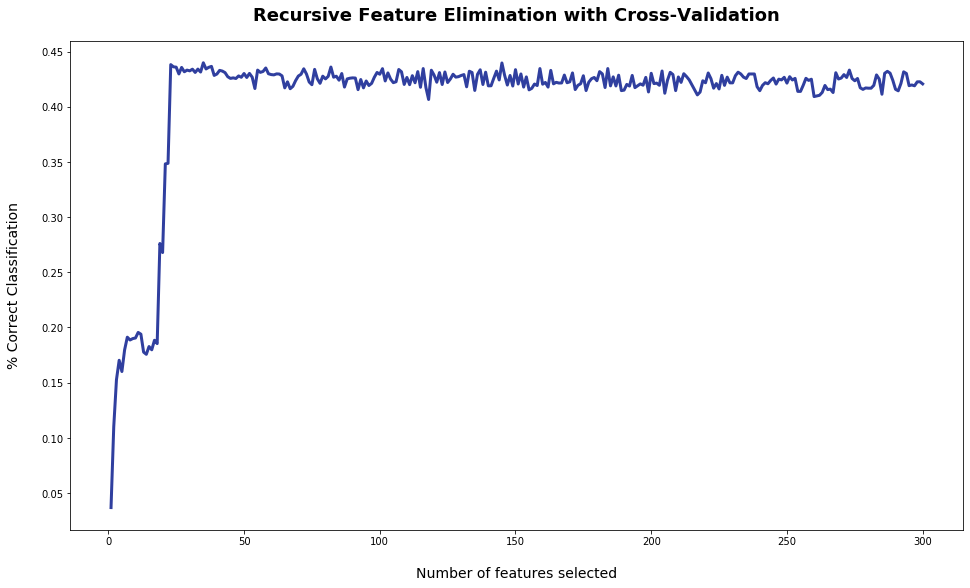

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [30]:
dset = pd.DataFrame()
# dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)
print(dset)

    importance
17         921
19         864
4          683
3          551
15         516
20         504
7          384
0          383
6          371
18         357
24         351
9          338
29         306
34         304
5          301
33         300
27         281
26         279
2          272
14         271
10         266
23         256
8          254
22         246
1          244
21         244
31         241
16         240
13         225
32         225
12         212
28         207
25         205
30         204
11         194


In [27]:
rfecv.estimator_.feature_importances_ 

array([383, 244, 272, 551, 683, 301, 371, 384, 254, 338, 266, 194, 212,
       225, 271, 516, 240, 921, 357, 864, 504, 244, 246, 256, 351, 205,
       279, 281, 207, 306, 204, 241, 225, 300, 304], dtype=int32)

In [28]:
rfecv.estimator_

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.75, importance_type='split',
               learning_rate=0.007, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [29]:
rfecv.ranking_ 

array([  1,   1,  60, 208,  82,  89,   1,   1,   1,   1,   1,  39,  18,
         1,   1,  80,  51,   1,  29,  88,  28,   1,  84, 204, 118,  99,
        85,   1,  53,  59, 101, 111,  32,  68,   1,  63,  75,   1,   6,
       143, 113, 122, 190, 248,  48,  15, 155,  41,  55,   1, 166,   5,
        24,  65,  79, 135,   1, 216,  33,   1,   1, 223,   1, 235, 217,
       218, 266,  76,   1, 236,   7,  19,   1, 247,   1,  31,  25, 250,
         1,   1,  37, 251,   1, 242, 256, 260, 262,   1, 127, 261,   1,
        12,  46, 238,   1,   9,   1, 179,  43,  61,   3,   1,  66, 171,
         1,  38,  13, 160, 121, 234, 230, 244, 227, 219, 226, 245,  26,
       107,  64,  14, 104,  54,  92,  91,  70,  96,  74, 100, 146,  78,
       126, 124, 167,  81,  95,  20, 130, 175,  35, 112, 147, 149,  10,
       139, 105, 163, 108,  30,  69, 174, 200, 246, 240, 169,  93,  56,
       180,  22, 151, 173, 177, 186,  71,   1,  58, 184, 158, 125, 144,
       120,  17, 161, 188, 189, 187, 228, 252, 138, 193, 206, 22

In [44]:
n = rfecv.estimator_.feature_importances_ 
l = list(np.argsort(-n))
X.columns[l]

Index(['dow_3', 'dow_5', 'game_time_max', 'game_time_min', 'dow_1', 'dow_6',
       'Assessment', 'title', 'Activity', 'dow_4', 'h_11', 'Game', 'h_16',
       'h_20', 'game_time_std', 'h_2', 'h_14', 'h_13', 'game_time_sum',
       'dow_0', 'CRYSTALCAVES', 'h_10', 'Clip', 'h_1', 'game_time_mean', 'h_0',
       'h_18', 'dow_2', 'TREETOPCITY', 'h_19', 'NONE', 'h_15', 'h_12', 'h_17',
       'MAGMAPEAK'],
      dtype='object')

TypeError: ('game_time', 'max', 'Activity') is not a string

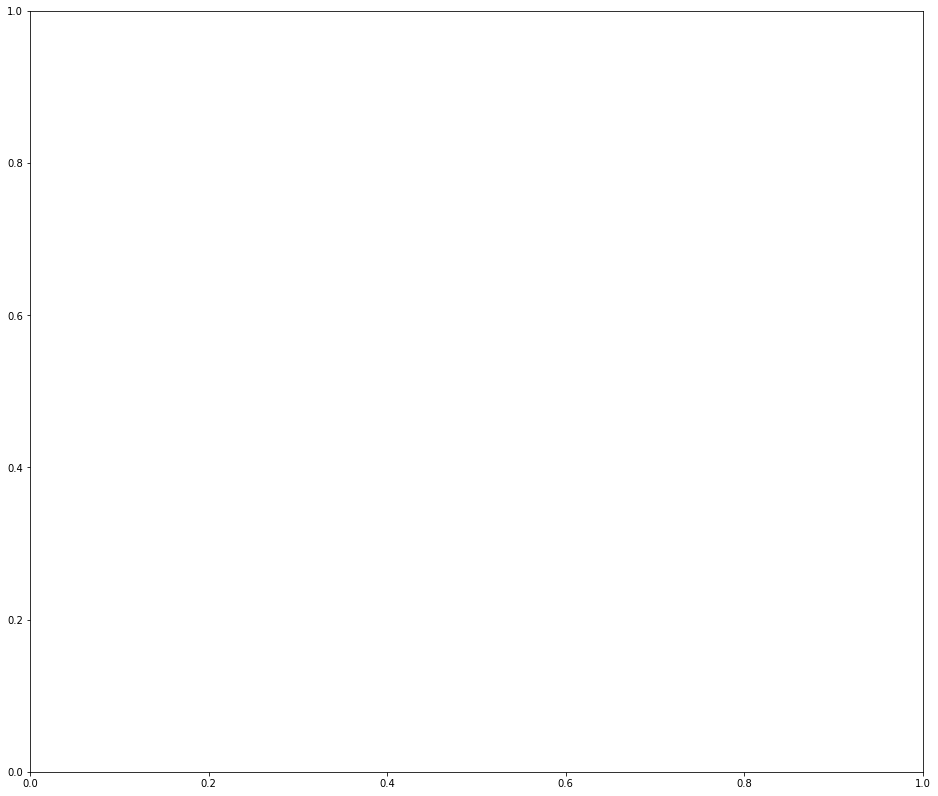

In [25]:
dset = pd.DataFrame()
# dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=X.columns, width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [18]:
y_pred = run_model(comp_train_df, comp_test_df)

Run model

Fold 1

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.09259	valid_1's multi_logloss: 1.13418
[200]	training's multi_logloss: 1.02577	valid_1's multi_logloss: 1.09434
[300]	training's multi_logloss: 0.981659	valid_1's multi_logloss: 1.07315
[400]	training's multi_logloss: 0.949538	valid_1's multi_logloss: 1.0632
[500]	training's multi_logloss: 0.924253	valid_1's multi_logloss: 1.05747
[600]	training's multi_logloss: 0.903366	valid_1's multi_logloss: 1.05577
[700]	training's multi_logloss: 0.885342	valid_1's multi_logloss: 1.0554
Early stopping, best iteration is:
[687]	training's multi_logloss: 0.887544	valid_1's multi_logloss: 1.05521


<ipython-input-10-aea357dc8b2c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "qwk3" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-10-aea357dc8b2c> (3)

File "<ipython-input-10-aea357dc8b2c>", line 3:
def qwk3(a1, a2, max_rat=3):
    assert(len(a1) == len(a2))
    ^

  @jit
<ipython-input-10-aea357dc8b2c>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qwk3" failed type inference due to: Unsupported constraint encountered: raise $16.1

File "<ipython-input-10-aea357dc8b2c>", line 3:
def qwk3(a1, a2, max_rat=3):
    assert(len(a1) == len(a2))
    ^

  @jit
/opt/conda/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "qwk3" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-10-aea357dc8b2c>", line 2:
@jit
def qwk3(a1, a2, max_rat=3):
^

  

Fold: 1 quadratic weighted kappa score: 0.4308

Fold 2

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.09042	valid_1's multi_logloss: 1.15911
[200]	training's multi_logloss: 1.02052	valid_1's multi_logloss: 1.12567
[300]	training's multi_logloss: 0.976764	valid_1's multi_logloss: 1.11201
[400]	training's multi_logloss: 0.945227	valid_1's multi_logloss: 1.10655
[500]	training's multi_logloss: 0.920123	valid_1's multi_logloss: 1.10324
[600]	training's multi_logloss: 0.899168	valid_1's multi_logloss: 1.10243
[700]	training's multi_logloss: 0.881032	valid_1's multi_logloss: 1.10319
Early stopping, best iteration is:
[602]	training's multi_logloss: 0.898755	valid_1's multi_logloss: 1.10241
Fold: 2 quadratic weighted kappa score: 0.416

Fold 3

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 1.09231	valid_1's multi_logloss: 1.14414
[200]	training's multi_logloss: 1.02233	valid_1's multi_logloss: 1.

In [19]:
prepare_submission(comp_test_df, sample_submission_df, y_pred)